In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
imagesize=256
batchsize=32
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potatodisease",
    seed=123,
    shuffle=True,
    image_size=(imagesize,imagesize),
    batch_size=batchsize
)

Found 2152 files belonging to 3 classes.


In [3]:
class_names = dataset.class_names
print("Classes:", class_names)

Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


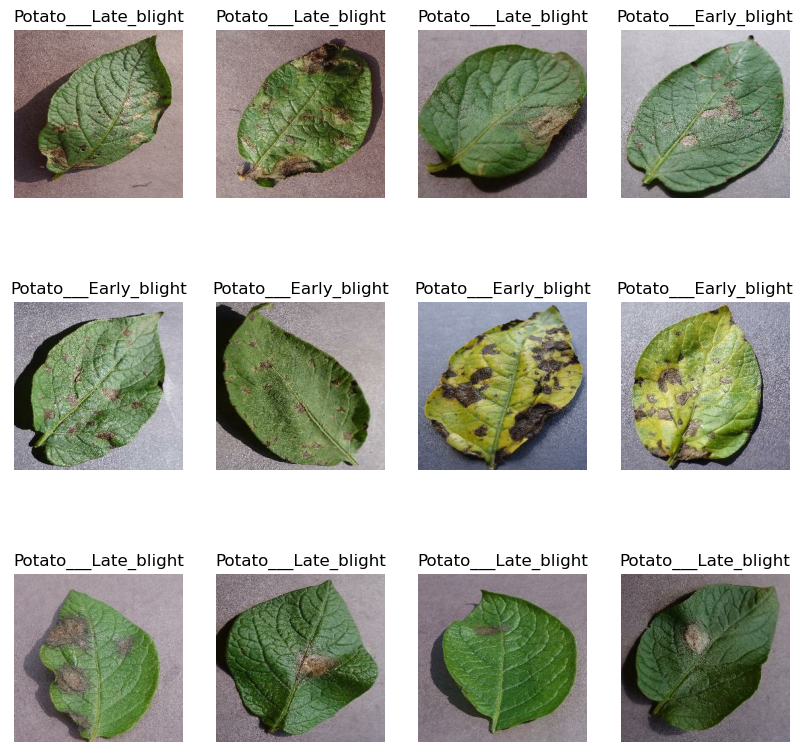

In [4]:
import matplotlib.pyplot as plt

for image_batch, labels_batch in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [5]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(imagesize, imagesize),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [6]:
def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1):
    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(dataset)
print(f"Train size: {len(train_ds)}, Validation size: {len(val_ds)}, Test size: {len(test_ds)}")

Train size: 54, Validation size: 6, Test size: 8


In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [9]:
import os

imgsize = 64
features, labels = [], []

for image_batch, labels_batch in dataset.unbatch().take(500):
    image = tf.image.resize(image_batch, (imgsize,imgsize)).numpy()
    features.append(image.flatten())
    labels.append(labels_batch.numpy())

features = np.array(features)
labels = np.array(labels)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3,metric='euclidean')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

knn_acc = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:", knn_acc)
print(classification_report(y_test,y_pred_knn))

KNN Accuracy: 0.6933333333333334
              precision    recall  f1-score   support

           0       0.97      0.49      0.65        69
           1       0.63      0.94      0.75        71
           2       0.38      0.30      0.33        10

    accuracy                           0.69       150
   macro avg       0.66      0.58      0.58       150
weighted avg       0.77      0.69      0.68       150



In [12]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

dt_acc = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", dt_acc)
print(classification_report(y_test,y_pred_dt))

Decision Tree Accuracy: 0.7333333333333333
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        69
           1       0.78      0.80      0.79        71
           2       0.00      0.00      0.00        10

    accuracy                           0.73       150
   macro avg       0.52      0.52      0.52       150
weighted avg       0.73      0.73      0.73       150



In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_acc = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", rf_acc)
print(classification_report(y_test,y_pred_rf))

Random Forest Accuracy: 0.8533333333333334
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        69
           1       0.82      0.90      0.86        71
           2       1.00      0.10      0.18        10

    accuracy                           0.85       150
   macro avg       0.90      0.64      0.65       150
weighted avg       0.86      0.85      0.83       150



In [14]:
from sklearn.svm import SVC
svm_model = SVC(kernel='linear',decision_function_shape='ovr', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

svm_acc = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", svm_acc)
print(classification_report(y_test,y_pred_svm))

SVM Accuracy: 0.8933333333333333
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        69
           1       0.87      0.93      0.90        71
           2       0.60      0.30      0.40        10

    accuracy                           0.89       150
   macro avg       0.80      0.72      0.75       150
weighted avg       0.88      0.89      0.89       150



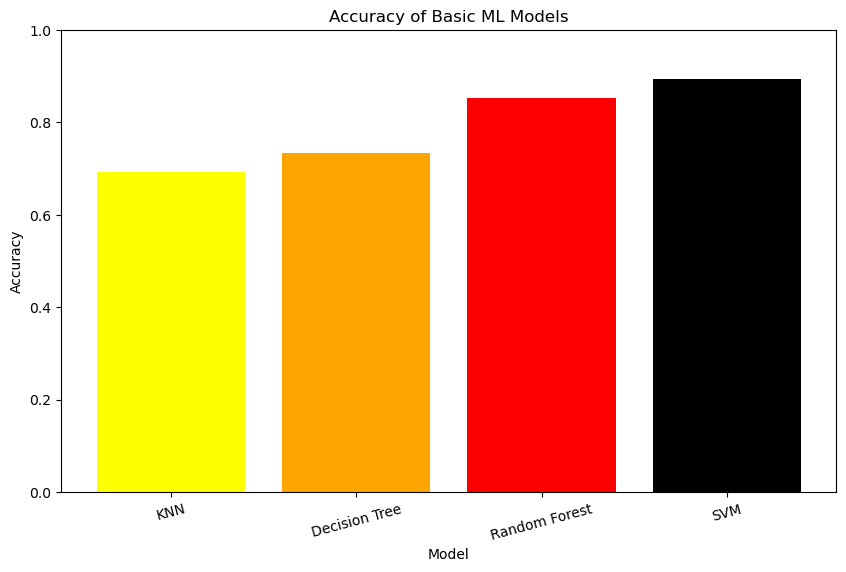

In [15]:
import matplotlib.pyplot as plt

model_names = ['KNN', 'Decision Tree', 'Random Forest', 'SVM']
accuracies = [knn_acc,
              dt_acc,
              rf_acc,
              svm_acc
              ]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=[ 'yellow', 'orange', 'red', 'black'])
plt.title('Accuracy of Basic ML Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.show()


In [16]:
channels=3
input_shape = (batchsize, imagesize,imagesize, channels)
n_classes = 3

cnn_model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

cnn_model.build(input_shape=input_shape)

In [17]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [18]:
cnn_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = cnn_model.fit(
    train_ds,
    batch_size=batchsize,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 249s 5s/step - loss: 0.8676 - accuracy: 0.5625 - val_loss: 0.6597 - val_accuracy: 0.7448
Epoch 2/50
54/54 [==============================] - 252s 5s/step - loss: 0.5279 - accuracy: 0.7720 - val_loss: 0.2961 - val_accuracy: 0.9062
Epoch 3/50
54/54 [==============================] - 258s 5s/step - loss: 0.2792 - accuracy: 0.8848 - val_loss: 0.2427 - val_accuracy: 0.8906
Epoch 4/50
54/54 [==============================] - 306s 6s/step - loss: 0.2791 - accuracy: 0.8883 - val_loss: 0.2199 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 343s 6s/step - loss: 0.2068 - accuracy: 0.9167 - val_loss: 0.1543 - val_accuracy: 0.9271
Epoch 6/50
54/54 [==============================] - 329s 6s/step - loss: 0.1902 - accuracy: 0.9271 - val_loss: 0.2588 - val_accuracy: 0.8906
Epoch 7/50
54/54 [==============================] - 283s 5s/step - loss: 0.1532 - accuracy: 0.9398 - val_loss: 0.2613 - val_accuracy: 0.8958
Epoch 8/50
54

In [20]:
scores = cnn_model.evaluate(test_ds)

8/8 [==============================] - 10s 1s/step - loss: 0.1874 - accuracy: 0.9353


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [22]:
def plot_training_history(history, title='Model Performance'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'g', label='Train Acc')
    plt.plot(epochs, val_acc, 'b', label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Train Loss')
    plt.plot(epochs, val_loss, 'orange', label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

In [23]:
def plot_confusion_matrix(model, dataset, class_names):
    y_true, y_pred = [], []

    for images, labels in dataset:
        preds = model.predict(images)
        preds = np.argmax(preds, axis=1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    print("\n Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)
    
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

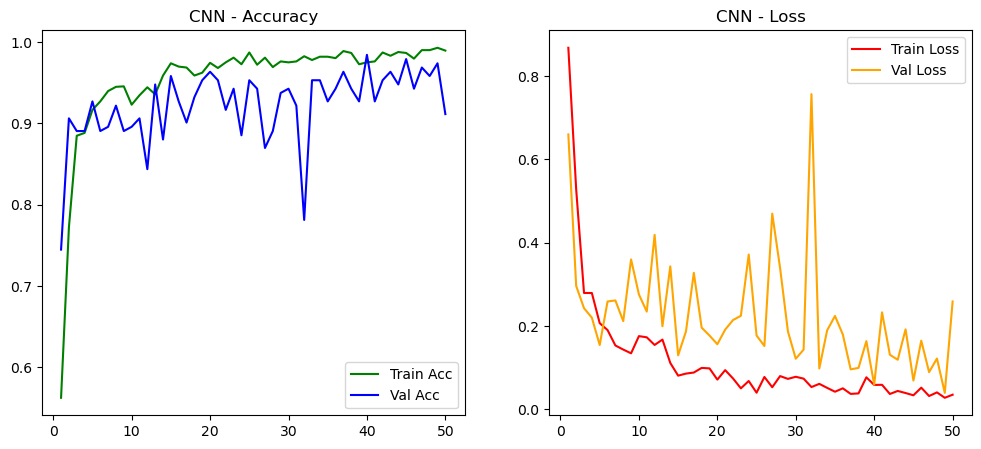

In [24]:
class_names = ["Early Blight", "Late Blight", "Healthy"]
plot_training_history(history, title="CNN")

1/1 [==============================] - 1s 742ms/step


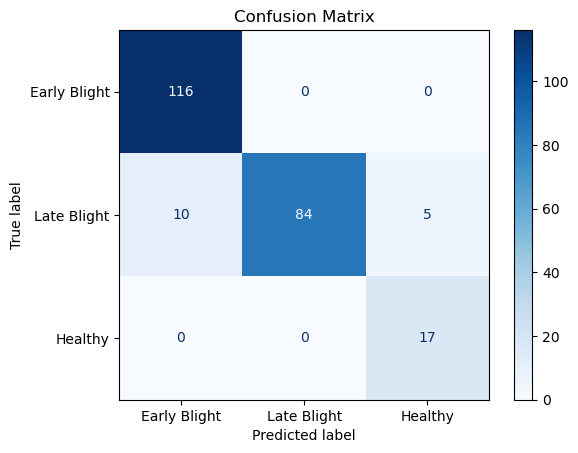


 Classification Report:
              precision    recall  f1-score   support

Early Blight       0.92      1.00      0.96       116
 Late Blight       1.00      0.85      0.92        99
     Healthy       0.77      1.00      0.87        17

    accuracy                           0.94       232
   macro avg       0.90      0.95      0.92       232
weighted avg       0.94      0.94      0.93       232

Accuracy:  0.9353
Precision: 0.9437
Recall:    0.9353
F1 Score:  0.9350


In [25]:
plot_confusion_matrix(cnn_model, test_ds, class_names)

In [26]:
cnn_model.save("cnn.h5")

In [27]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

model = load_model("cnn.h5")


class_names = ["Early Blight", "Late Blight", "Healthy"]

def load_and_preprocess_image(path, target_size=(256, 256)):
    image = Image.open(path).convert('RGB')
    image = image.resize(target_size)
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, image

1/1 [==============================] - 0s 49ms/step


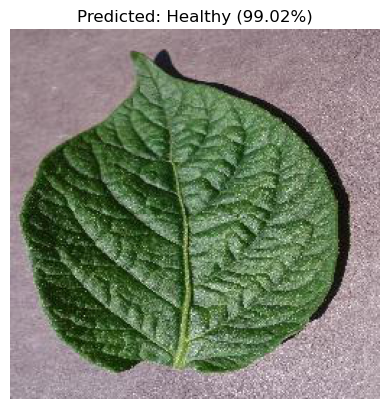

In [45]:
image_path = "C:/Users/ridhs/Downloads/potato (1)/potato/healthy/PotatoHealthy(5).JPG"
img_array, original_image = load_and_preprocess_image(image_path)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
confidence = np.max(predictions)

plt.imshow(original_image)
plt.axis('off')
plt.title(f"Predicted: {class_names[predicted_class]} ({confidence*100:.2f}%)")
plt.show()